In [1]:
!pip3 install xgboost

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
    100% |████████████████████████████████| 675kB 3.0MB/s ta 0:00:01
^C
Operation cancelled by user


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime
from sklearn.model_selection import train_test_split


In [57]:
train = pd.read_csv('./data/train.csv')

In [58]:
print(train['price_doc'].describe())

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64


In [59]:

train = train[train.price_doc < 20849558]
train = train[train.price_doc > 1200000]
train.dropna(subset=["full_sq"])
train=train[train.full_sq >0]




In [60]:
X = train.drop(["id", "timestamp", "price_doc"], axis=1)
y = train["price_doc"]
x_train, x_test, y_train, y_test = train_test_split(
     X, y, test_size=0.30, random_state=42)

#can't merge train with test because the kernel run for very long time

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values))
        x_train[c] = lbl.transform(list(x_train[c].values))
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))

/Users/baranberkaybarakcin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/baranberkaybarakcin/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [61]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

[0]	train-rmse:6.9604e+06	test-rmse:6.97321e+06
[50]	train-rmse:787031	test-rmse:1.87527e+06


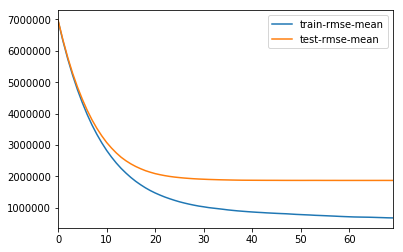

In [62]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [63]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

[21:28:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


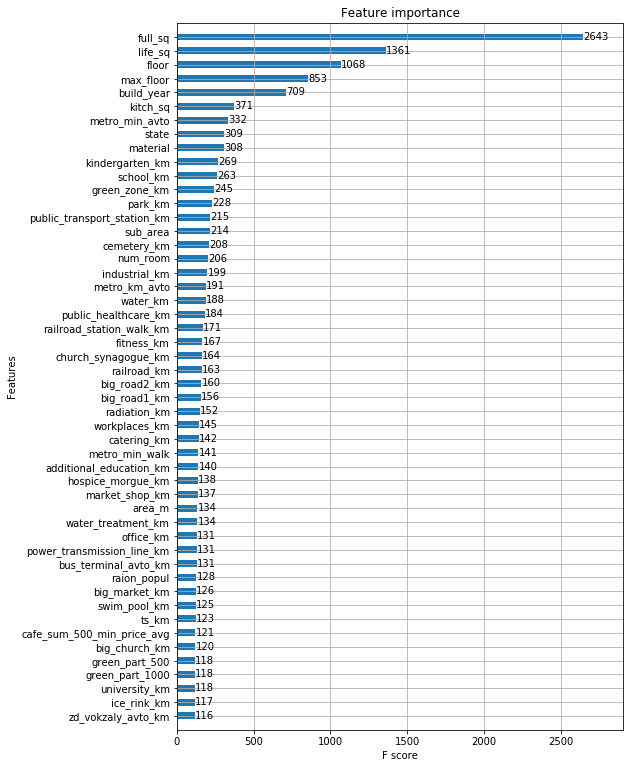

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [84]:
x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_test.mean())
x_train = x_train[['full_sq', 'life_sq', 'floor', 'build_year', 'max_floor', 'kitch_sq', 'num_room', 'state','school_km','material']]
x_test = x_test[['full_sq', 'life_sq', 'floor', 'build_year', 'max_floor', 'kitch_sq', 'num_room', 'state','school_km','material']]

In [85]:
from sklearn import metrics
from math import sqrt
def root_mean_squared_log_error(y_true, y_pred):
    ''' Root mean squared error regression loss
    
    Parameters
    ----------
    y_true : array-like of shape = (n_samples) or (n_samples, n_outputs)
    Ground truth (correct) target values.

    y_pred : array-like of shape = (n_samples) or (n_samples, n_outputs)
    Estimated target values.
    '''
    return np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))

In [97]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)
regressor = DecisionTreeRegressor()
depths = np.arange(1, 21)
num_leafs = [1, 5, 10, 20, 50, 100]
param_grid = [{'max_depth':depths,
              'min_samples_leaf':num_leafs,
              'min_samples_split':[30]}]
gs = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring=rmsle_scorer, cv=10)
gs = gs.fit(x_train, y_train)
print(-gs.best_score_)
print(gs.best_params_)
regressor = gs.best_estimator_

0.34357327971893015
{'max_depth': 11, 'min_samples_leaf': 20, 'min_samples_split': 30}


In [98]:
print("R-Squared on train dataset={}".format(regressor.score(x_train, y_train))) 

R-Squared on train dataset=0.6237357493439064


In [99]:
from sklearn import metrics
from math import sqrt
y_pred = regressor.predict(x_test)
sqrt(metrics.mean_squared_log_error(y_test, y_pred))


0.38841392580122136